In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
import os,sys
import cv2
from tqdm import tqdm
import re
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


from tensorflow.keras import models, Sequential, layers, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory 

# VGG19 import
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [7]:
path_train = '/kaggle/input/stanford-dogs-dataset-traintest/cropped/train'
path_test = '/kaggle/input/stanford-dogs-dataset-traintest/cropped/test'b

# Functions

In [8]:
# Functions for loading data, creating X and y, and encoding y
def load_images(path:str):
  '''
  Load images from the Dog Dataset of Kaggle.
  Returns X and y as numpy arrays
  '''
  X = []
  y = []
  # Use os.walk to iterate over all the subdirectories and files within the given directory
  for subdir, dirs, files in os.walk(path):
      for file in files:
          # Extract the label from the path
          # remove .split("-")[1] if you want to keep the ID
          label = os.path.basename(os.path.normpath(subdir)).split("-")[1]
          # Load the image using OpenCV
          img_path = os.path.join(subdir, file)
          img = cv2.imread(img_path)
          # Add the image data and label to the X and y arrays
          X.append(img)
          y.append(label)
  # Convert X and y to NumPy arrays and return them
  return np.array(X), np.array(y)


def load_images_and_preprocess(path):
    '''
    Load images from the Dog Dataset of Kaggle.
    Returns X and y as numpy arrays
    Encode labels as categorical variables
    '''
    X, y = load_images(path)
#     assert X.shape == (12000, 224, 224, 3), f"Expected X to have shape (12000, 224, 224, 3), but got {X.shape}. Please check that you provided the correct path and that all images are loaded correctly."
    l_e = LabelEncoder()
    y = l_e.fit_transform(y)
    y = to_categorical(y)
    return X, y

In [35]:
# Function for plotting the loss and accuracy 
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
def plot_compare_history(history, name_history, history_1, name_history_1):
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].set_title('loss')
    
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)
    
    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)
    
    ax[1].set_title('Accuracy')
    
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)
    
    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)
    
    ax[0].legend()
    ax[1].legend()

# Create X_train and y_train from the train dataset 

In [9]:
# Create X and y from the train dataset
X_train, y_train = load_images_and_preprocess(path_train)
X_train.shape, y_train.shape

((12000, 224, 224, 3), (12000, 120))

# Create X_test and y_test from the test dataset 

In [11]:
# Create X and y from the test dataset
X_test, y_test = load_images_and_preprocess(path_test)
X_test.shape, y_test.shape

((8580, 224, 224, 3), (8580, 120))

# Load the images batch by batch and preprocess X_train, X_val and X_test

In [24]:
# Train dataset
train_dataset = image_dataset_from_directory(directory=path_train,
                                      labels='inferred',
                                      label_mode="categorical",
                                      validation_split=0.2,
                                      subset="training",
                                      seed=123,
                                      image_size=(224, 224),
                                      batch_size=32)   

# Preprocess X in the train_dataset
preprocessed_train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y)) 

Found 12000 files belonging to 120 classes.
Using 9600 files for training.


In [25]:
# Validation dataset
val_dataset = image_dataset_from_directory(directory=path_train,
                                      labels='inferred',
                                      label_mode="categorical",
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=123,
                                      image_size=(224, 224),
                                      batch_size=32)
                                         
# Preprocess X in the val_dataset
preprocessed_val_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y)) 

Found 12000 files belonging to 120 classes.
Using 2400 files for validation.


In [26]:
# Test dataset 
test_dataset = image_dataset_from_directory(directory=path_test,
                                            labels='inferred',
                                            label_mode="categorical",
                                            validation_split=None,
                                            subset=None,
                                            seed=123,
                                            image_size=(224, 224),
                                            batch_size=32) 

# Preprocess X in the test_dataset
preprocessed_test_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y)) 

Found 8580 files belonging to 120 classes.


In [31]:
# Check the preprocessed X in the train_dataset
image_batch_train, labels_batch_train = next(iter(preprocessed_train_dataset))
first_image_train = image_batch_train[0]
first_image_train
print("from the train dataset")
print(image_batch_train.shape)
print(np.min(first_image_train), np.max(first_image_train))

# Check the preprocessed X in the val_dataset
image_batch_val, labels_batch_val = next(iter(preprocessed_val_dataset))
first_image_val = image_batch_val[0]
first_image_val
print("from the val dataset")
print(image_batch_val.shape)
print(np.min(first_image_val), np.max(first_image_val))

# Check the preprocessed X in the test_dataset
image_batch_test, labels_batch_test = next(iter(preprocessed_test_dataset))
first_image_test = image_batch_test[0]
first_image_test
print("from the test dataset")
print(image_batch_test.shape)
print(np.min(first_image_test), np.max(first_image_test))

from the train dataset
(32, 224, 224, 3)
-116.779 133.061
from the val dataset
(32, 224, 224, 3)
-123.68 151.061
from the test dataset
(32, 224, 224, 3)
-120.68 151.061


In [ ]:
# Get the class_names (breed names)
# class_names = train_dataset.class_names

# class_names = [re.findall('n\d{8}-(.*)', i)[0][:-1].capitalize() for i in class_names]
# print(class_names)
# len(class_names)

# VGG19 Models

In [15]:
# LOAD THE VGG19 MODEL
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


### MODEL 1 with two hidden dense layers

In [16]:
# Initialize MODEL 1

model_1 = Sequential([layers.Input(shape=(224,224,3)),
                      base_model,
                      layers.Flatten(),
                      layers.Dense(100, activation="relu"),
                      layers.Dense(100, activation="relu"),   
                      layers.Dense(120, activation='softmax')
                     ])

opt = optimizers.Adam(learning_rate=1e-4)
model_1.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 120)               12120     
                                                                 
Total params: 22,555,504
Trainable params: 2,531,120
Non-trainable params: 20,024,384
_________________________________________________________________


In [34]:
# Train/fit the MODEL 1 with preprocessed X_train and preprocessed X_val
MODEL = "model_1"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history_1 = model_1.fit(preprocessed_train_dataset,
                    validation_data=preprocessed_val_dataset, 
                    epochs=10,  
                    batch_size=32,
                    callbacks=[es, mcp])

Epoch 1/10
300/300 [==============================] - 72s 240ms/step - loss: 5.2025 - accuracy: 0.0135 - val_loss: 4.6085 - val_accuracy: 0.0316
Epoch 2/10
300/300 [==============================] - 72s 239ms/step - loss: 4.4542 - accuracy: 0.0584 - val_loss: 4.0308 - val_accuracy: 0.1203
Epoch 3/10
300/300 [==============================] - 62s 205ms/step - loss: 3.7757 - accuracy: 0.1628 - val_loss: 3.0648 - val_accuracy: 0.2795
Epoch 4/10
300/300 [==============================] - 61s 204ms/step - loss: 2.8251 - accuracy: 0.3281 - val_loss: 2.1316 - val_accuracy: 0.4657
Epoch 5/10
300/300 [==============================] - 72s 241ms/step - loss: 2.0031 - accuracy: 0.4840 - val_loss: 1.4380 - val_accuracy: 0.6055
Epoch 6/10
300/300 [==============================] - 61s 202ms/step - loss: 1.3356 - accuracy: 0.6268 - val_loss: 0.9244 - val_accuracy: 0.7356
Epoch 7/10
300/300 [==============================] - 72s 239ms/step - loss: 0.8831 - accuracy: 0.7452 - val_loss: 0.6341 - val_ac

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

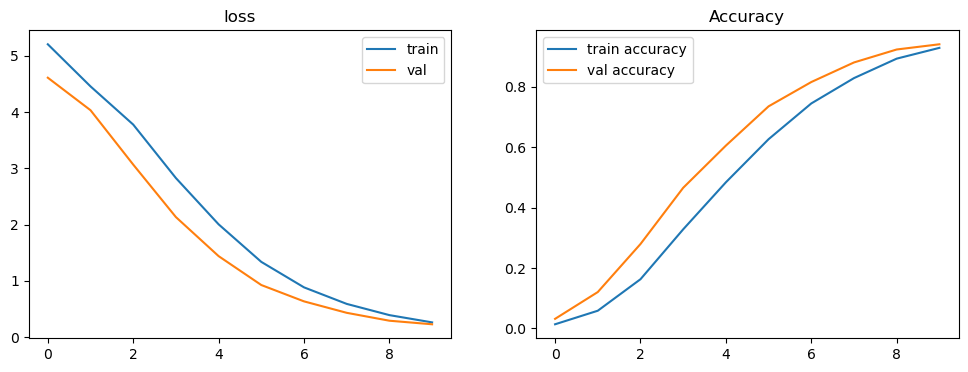

In [37]:
# Plot the loss and accuracy for MODEL 1
plot_history(history_1, title="Model 1")

In [39]:
# Evaluate MODEL 1 on the test dataset
res_model_1 = model_1.evaluate(preprocessed_test_dataset)
test_accuracy_model_1 = res_model_1[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_1,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

300/300 [==============================] - 31s 101ms/step - loss: 0.2270 - accuracy: 0.9413
test_accuracy_model_1 = 94.0 %
Chance level: 0.8%


### MODEL 2 = MODEL 1 with data augmentation

In [40]:
# Initialize MODEL 2
model_2 = Sequential([layers.Input(shape=(224,224,3)),
                      layers.RandomFlip("horizontal"),
                      layers.RandomZoom(0.1),
                      layers.RandomTranslation(0.2,0.2),
                      layers.RandomRotation(0.1),
                      base_model,
                      layers.Flatten(),
                      layers.Dense(100, activation="relu"),
                      layers.Dense(100, activation="relu"),   
                      layers.Dense(120, activation='softmax')
                     ])

opt = optimizers.Adam(learning_rate=1e-4)
model_2.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)            

In [43]:
# Train/fit the MODEL 2 with preprocessed X_train and preprocessed X_val
MODEL = "model_2"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history_2 = model_2.fit(preprocessed_train_dataset,
                    validation_data=preprocessed_val_dataset, 
                    epochs=20,  
                    batch_size=32,
                    callbacks=[es, mcp])

Epoch 1/20
300/300 [==============================] - 141s 468ms/step - loss: 4.7668 - accuracy: 0.0193 - val_loss: 4.6880 - val_accuracy: 0.0371
Epoch 2/20
300/300 [==============================] - 152s 507ms/step - loss: 4.6076 - accuracy: 0.0439 - val_loss: 4.3505 - val_accuracy: 0.0918
Epoch 3/20
300/300 [==============================] - 152s 505ms/step - loss: 4.2670 - accuracy: 0.0934 - val_loss: 3.9095 - val_accuracy: 0.1601
Epoch 4/20
300/300 [==============================] - 152s 506ms/step - loss: 3.8541 - accuracy: 0.1422 - val_loss: 3.3470 - val_accuracy: 0.2216
Epoch 5/20
300/300 [==============================] - 141s 470ms/step - loss: 3.3957 - accuracy: 0.1994 - val_loss: 2.8579 - val_accuracy: 0.2924
Epoch 6/20
300/300 [==============================] - 152s 505ms/step - loss: 3.0421 - accuracy: 0.2499 - val_loss: 2.4730 - val_accuracy: 0.3469
Epoch 7/20
300/300 [==============================] - 141s 469ms/step - loss: 2.7516 - accuracy: 0.2889 - val_loss: 2.1904 -

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

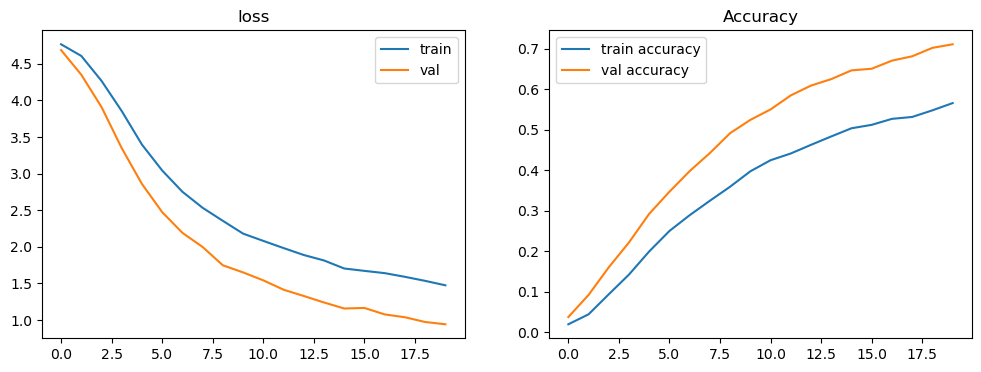

In [44]:
# Plot the loss and accuracy for MODEL 2
plot_history(history_2, title="Model 2")

In [45]:
# Evaluate MODEL 2 on the test dataset
res_model_2 = model_2.evaluate(preprocessed_test_dataset)
test_accuracy_model_2 = res_model_2[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_2,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

300/300 [==============================] - 30s 100ms/step - loss: 0.9410 - accuracy: 0.7111
test_accuracy_model_1 = 71.0 %
Chance level: 0.8%


#### Observation: Comparing MODEL 1 and MODEL 2: data augmentation decreases the performance. 
#### Possible explanation: data augmentation is useful if a model is overfitting, which is not the case for MODEL 1 (MODEL 1 seems not overfitting)




🥡 Some takeaways from Data Augmentation:
(Source: cifar_classification and transfer_learning)

Data augmentation may not improve your performance easily... (Data Augmentation can be useful if the model is overfitting)

Here it even decreased the performance!

Its impact strongly depends on:

* the model architecture you used
* the learning rate,
* the type of augmentation chosen, etc...
Image classification is an art that requires months and years of practice to master!

### MODEL 3 = MODEL 1 with dropout (30%)

In [46]:
# Initialize MODEL 3
model_3 = Sequential([layers.Input(shape=(224,224,3)),
                      base_model,
                      layers.Flatten(),
                      layers.Dense(100, activation="relu"),
                      layers.Dropout(0.3),
                      layers.Dense(100, activation="relu"),
                      layers.Dropout(0.3),
                      layers.Dense(120, activation='softmax')
                     ])

opt = optimizers.Adam(learning_rate=1e-4)
model_3.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
model_3.summary()


In [ ]:
# Train/fit the MODEL 3 with preprocessed X_train and preprocessed X_val
MODEL = "model_3"

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history_3 = model_3.fit(preprocessed_train_dataset,
                    validation_data=preprocessed_val_dataset, 
                    epochs=20,  
                    batch_size=32,
                    callbacks=[es, mcp])

In [47]:
# Plot the loss and accuracy for MODEL 2
plot_history(history_3, title="Model 3")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_1 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)            

In [ ]:
# Evaluate MODEL 23on the test dataset
res_model_2 = model_2.evaluate(preprocessed_test_dataset)
test_accuracy_model_2 = res_model_2[-1]
print(f"test_accuracy_model_1 = {round(test_accuracy_model_2,2)*100} %")
print(f'Chance level: {1./120*100:.1f}%')

# Prediction

In [161]:
# Get the class_names (breed names)
class_names = train_dataset.class_names

class_names = [re.findall('n\d{8}-(.*)', i)[0].capitalize() for i in class_names]
print(class_names)
len(class_names)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-tzu', 'Blenheim_spaniel', 'Papillon', 'Toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'Redbone', 'Borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'Whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'Otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'Wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'Cairn', 'Australian_terrier', 'Dandie_dinmont', 'Boston_bull', 'Miniature_schnauzer', 'Giant_schnauzer', 'Standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'Silky_terrier', 'Soft-coated_wheaten_terrier', 'West_highland_white_terrier', 'Lhasa', 'Flat-coated_retriever', 'Cur

120

In [47]:
# Use MODEL 1
model_1.save("model_1.h5")

In [48]:
# Load MODEL 1
from tensorflow.keras.models import load_model

model_1 = load_model("model_1.h5")

In [162]:
# Grabs an image based on its URL, and resize it
def getImage(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    img = img.resize((224, 224))
    return img

# Takes an image and a model
def predictImage(url, model):
    img = getImage(url)
    img = img_to_array(img)    #shape = (224, 224, 3)
    img = img.reshape((-1, 224, 224, 3))   #shape=(1, 224, 224, 3)
    img = preprocess_input(img)
    res = model.predict(img)
    
    indexes = np.argsort(res)[0][-3:][::-1]      #.argmax return the indices of the maximum values along an axis.
    first = indexes[0]
    second = indexes[1]
    third = indexes[2]
    
    predicts = np.sort(res)[0][::-1][0:3]
    predict_first = round(predicts[0],2)
    predict_second = round(predicts[1],2)
    predict_third = round(predicts[2],2)
    
    class_names = train_dataset.class_names
    class_names = [re.findall('n\d{8}-(.*)', i)[0].capitalize() for i in class_names]
    
    print(f"Top three breeds: {class_names[first]}, {class_names[second]}, {class_names[third]}")
    print(f"Top three probabilities = {predict_first*100} %, {predict_second*100} %, {predict_third*100} %")


In [184]:
dog1 = "https://www.purina.co.uk/sites/default/files/2022-07/French-Bulldog.jpg"
dog2 = "https://www.aspcapetinsurance.com/media/2325/facts-about-maltese-dogs.jpg"
dog3 = "https://www.akc.org/wp-content/uploads/2017/11/Chihuahua-standing-in-three-quarter-view.jpg"
dog4 = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog5 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

1/1 [==============================] - 0s 22ms/step
Top three breeds: French_bulldog, Boxer, Kelpie
Top three probabilities = 62.99999952316284 %, 37.00000047683716 %, 0.0 %


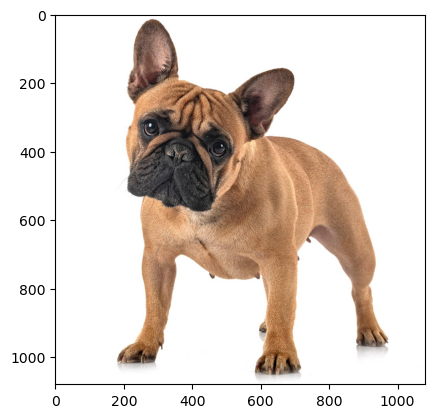

In [185]:
predictImage(dog1, model_1)

1/1 [==============================] - 0s 22ms/step
Top three breeds: Maltese_dog, Pembroke, Dandie_dinmont
Top three probabilities = 98.00000190734863 %, 0.9999999776482582 %, 0.9999999776482582 %


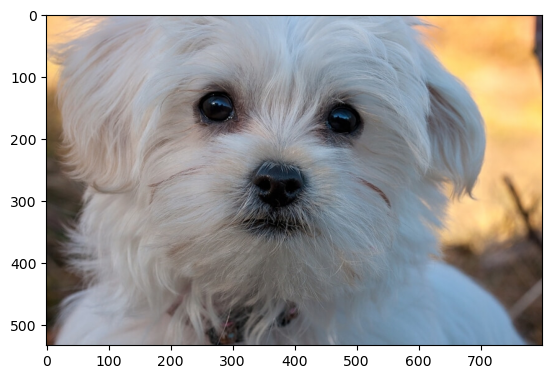

In [186]:
predictImage(dog2, model_1)

1/1 [==============================] - 0s 22ms/step
Top three breeds: Chihuahua, Toy_terrier, Whippet
Top three probabilities = 68.00000071525574 %, 23.999999463558197 %, 0.9999999776482582 %


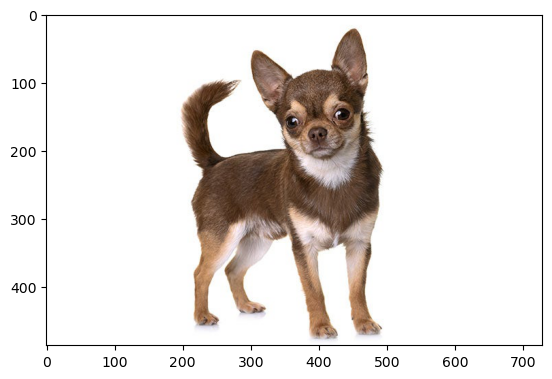

In [187]:
predictImage(dog3, model_1)

1/1 [==============================] - 0s 22ms/step
Top three breeds: Italian_greyhound, Chihuahua, Toy_terrier
Top three probabilities = 99.00000095367432 %, 0.9999999776482582 %, 0.0 %


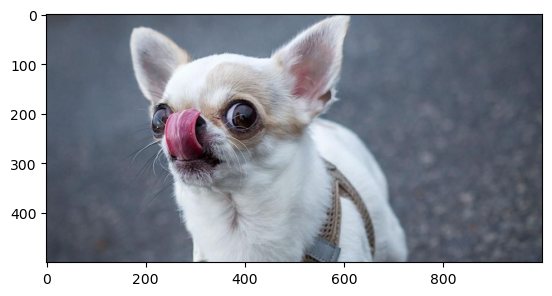

In [188]:
predictImage(dog4, model_1)

1/1 [==============================] - 0s 22ms/step
Top three breeds: Dingo, Great_dane, Saluki
Top three probabilities = 40.00000059604645 %, 18.000000715255737 %, 15.999999642372131 %


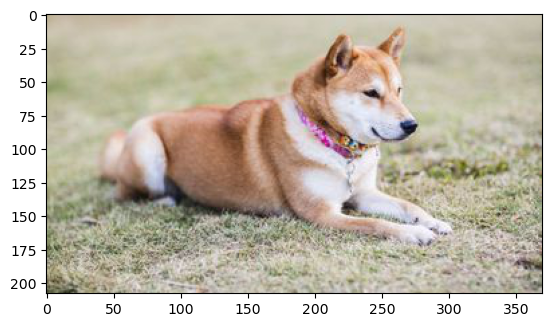

In [189]:
predictImage(dog5, model_1)